# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rich_clust


In [9]:
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2

import torch
from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random

In [24]:
# dir_github = Path(r'D:\RH_local\github').resolve()
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import paths

In [25]:
# dir_allOuterFolders = Path(r"D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6").resolve()
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()

folders_allSessions = path_helpers.get_dir_contents(dir_allOuterFolders)[0]

folders_toUse = folders_allSessions[0:]
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = "plane1/stat.npy"
pathSuffixToOps = "plane1/ops.npy"

paths_allStat = [path / pathSuffixToStat for path in dir_allS2pFolders]
paths_allOps  = [path / pathSuffixToOps for path in dir_allS2pFolders]

display(folders_allSessions)
display(folders_toUse)
display(dir_allS2pFolders)
display(paths_allStat)

['D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9']

['D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9']

[PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D1'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D10'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D11'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D12'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D13'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D14'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D2'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D3'),
 PosixPath('/media/

[PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D1/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D10/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D11/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D12/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D13/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D14/plane1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D2/plane1/stat.npy'),
 PosixPath('/media/rich/bigSS

In [26]:
pref_use_NN_distances = True

## NN fileNames
fileName_NN_pth = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth' # name of pth file in dir_NNmodels directory
fileName_NN_py  = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient' # EXCLUDE THE .PY AT THE END. name of py file in dir_NNmodels directory.

## Directories of Classifier stuff
dir_GRC_repo = dir_github / 'GCaMP_ROI_classifier'
dir_GRC_EndUser = dir_GRC_repo / 'End_User'
dir_NNmodels = dir_GRC_EndUser / 'simclr-models'
dir_GRC_util = dir_GRC_repo / 'new_stuff'

## Paths to NN and LR classifiers
path_NN_pth = dir_NNmodels / fileName_NN_pth
path_NN_py = dir_NNmodels / fileName_NN_py

display(path_NN_pth)
display(path_NN_py)

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth')

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient')

In [27]:
import sys
sys.path.append(str(dir_NNmodels))
sys.path.append(str(dir_github))
sys.path.append(str(dir_GRC_util))
sys.path.append(str(dir_GRC_EndUser))

%load_ext autoreload
%autoreload 2
import util
import simclr_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Settings (global)

In [28]:
use_GPU = True

# Alignment

In [29]:
## select and enhance images for registration

ops = [np.load(path, allow_pickle=True)[()] for path in paths_allOps]

meanIms = [ops[ii]['meanImgE'] for ii in range(len(ops))]
meanIms = apply_CLAHE(meanIms, clipLimit=40)

frame_height = meanIms[0].shape[0]
frame_width = meanIms[0].shape[1]

<IPython.core.display.Javascript object>


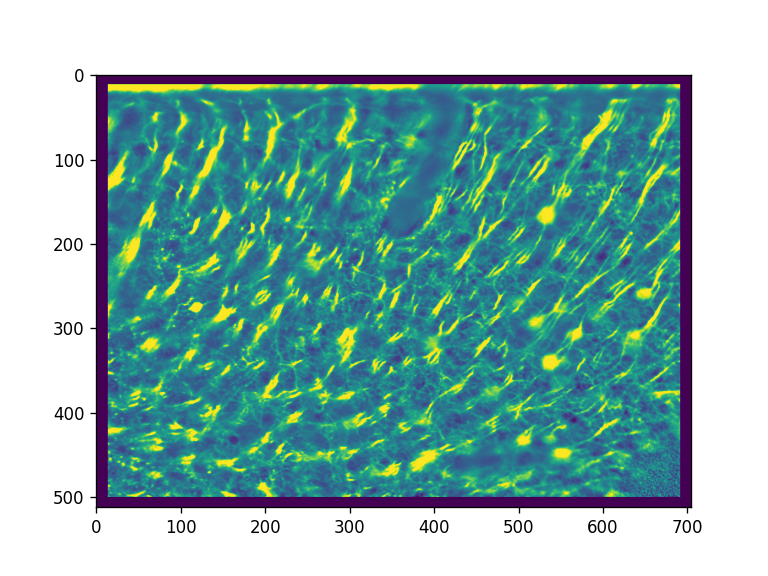

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [30]:
%matplotlib notebook
display_toggle_image_stack(meanIms, clim=None)

## Make spatial_footprints
- Make a lazy list of all the spatial_footprints
- Convert spatial footprints to a sparse array (`ROIs_aligned`)

In [31]:
sf_all = import_and_convert_to_CellReg_spatialFootprints(paths_allStat, frame_height=frame_height, frame_width=frame_width, dtype=np.float32)

ROIs_aligned, FOVs_aligned, flows = register_ROIs(meanIms[0], meanIms, sf_all, return_sparse=True, normalize=True)

n_sessions = len(ROIs_aligned)

n_roi_per_sesh = [sfs.shape[0] for sfs in ROIs_aligned]
n_roi_all = np.sum(n_roi_per_sesh)

In [32]:
## remove NaNs from ROIs
for ii in range(len(ROIs_aligned)):
    ROIs_aligned[ii].data[np.isnan(ROIs_aligned[ii].data)] = 0

Check to make sure the FOVs look aligned

<IPython.core.display.Javascript object>


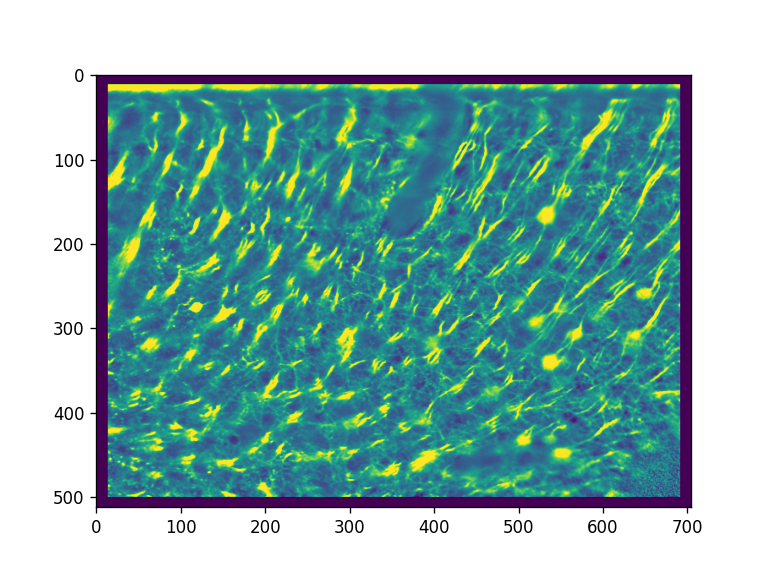

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [33]:
display_toggle_image_stack(FOVs_aligned, clim=None)

<IPython.core.display.Javascript object>


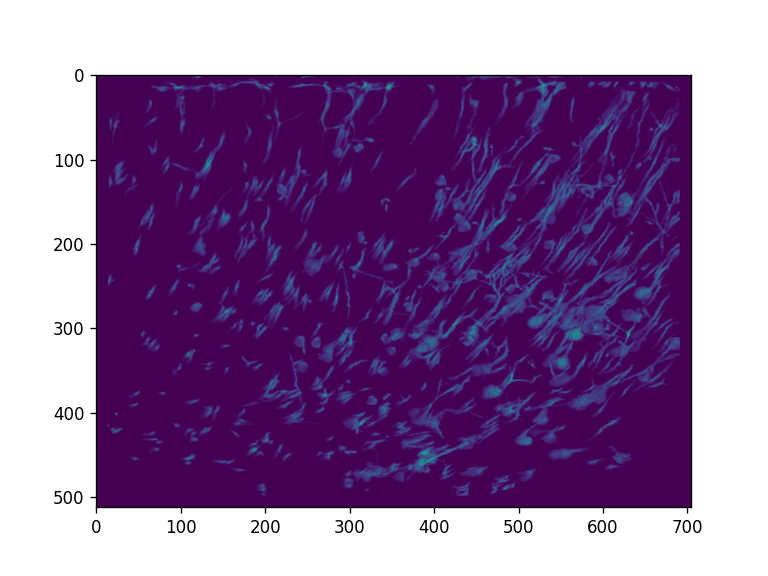

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [34]:
display_toggle_image_stack([rois.multiply( rois.max(1).power(-1) ).sum(0).reshape(frame_height, frame_width) for rois in ROIs_aligned], clim=None)

<IPython.core.display.Javascript object>


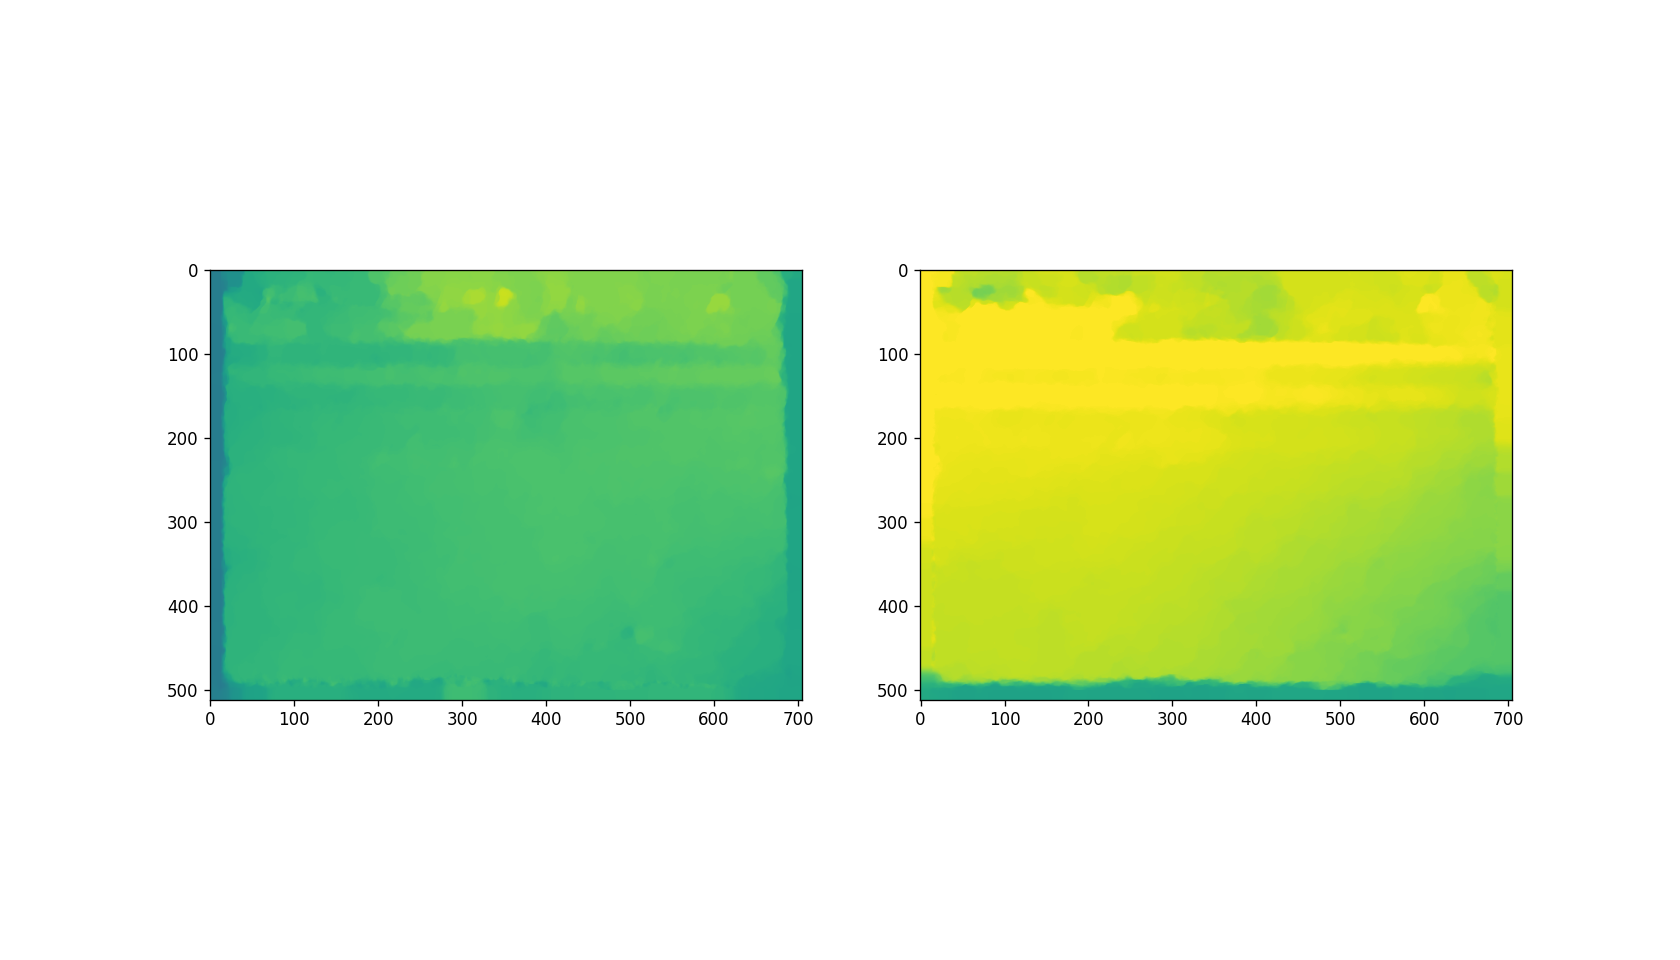

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [35]:
display_toggle_2channel_image_stack(flows, clim=(-20,20))

## Blur ROIs (optional)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


<IPython.core.display.Javascript object>


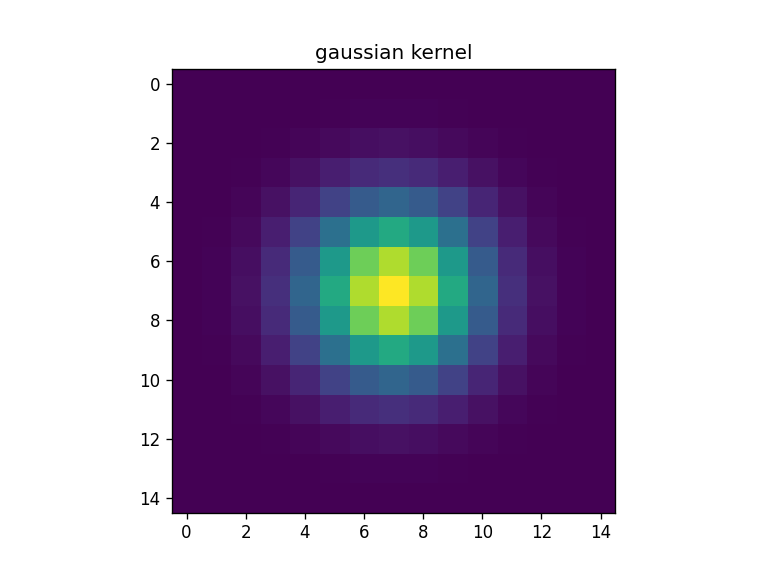

  0%|          | 0/14 [00:00<?, ?it/s]

In [36]:
## only needed if convolving ROIs and/or using neural net outputs for distance matrix
pref_blurROIs = True
DEVICE_blur = torch_helpers.set_device(use_GPU=use_GPU) # define torch device to use. either 'cpu', 'cuda', number, or something else. See torch_helpers.set_device()

if pref_blurROIs == True:
    kernel_size = 15 # Edge length of kernel image. Make odd number.
    kernel_sigma = 2 # sigma of 2D gaussian kernel
    kernel = featurization.gaussian_kernel_2D(center=(kernel_size//2, kernel_size//2), image_size=(kernel_size, kernel_size), sig=kernel_sigma)
    kernel = kernel / kernel.sum()

    ## show the kernel
    plt.figure()
    plt.imshow(kernel);
    plt.title('gaussian kernel')
    
    ROIs_aligned_blur = [batch_2D_sparse_convolution(
        images=rois, 
        kernel=kernel,
        image_shape=(frame_height, frame_width),
        num_batches=10,
        device=DEVICE_blur,
    ) for rois in tqdm(ROIs_aligned)]

<IPython.core.display.Javascript object>


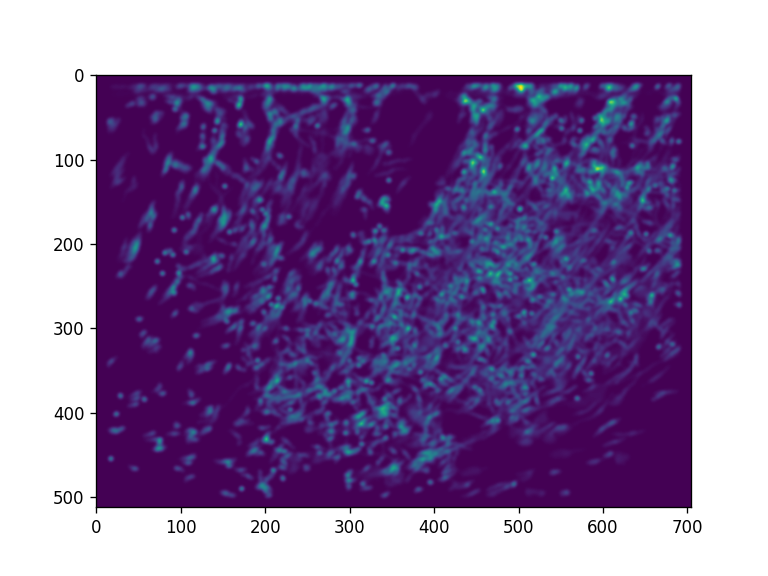

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [37]:
display_toggle_image_stack([ROIs.sum(0).reshape(frame_height, frame_width) for ROIs in ROIs_aligned_blur]) if pref_blurROIs else None

## Neural network embedding distances

In [38]:
sf_all_cropped = util.import_multiple_stat_files(
    paths_statFiles=paths_allStat, 
#     dir_statFiles=None,
#     fileNames_statFiles=None,
    out_height_width=[36,36], 
    max_footprint_width=441, 
    plot_pref=False
)

In [39]:
device_model = torch_helpers.set_device(use_GPU=use_GPU)

model, model_module = import_pth_model(path_NN_pth, fileName_NN_py)

data = np.concatenate(sf_all_cropped, axis=0)

if pref_use_NN_distances:
    # Create Data Sets / Data Loaders
    dataset, dataloader = model_module.get_dataset_dataloader(data, batch_size=64, device=device_model) ## TODO: Troubleshoot the runtime on this

    # Get Model Latents
    latents = simclr_helpers.dataloader_to_latents(dataloader, model.to(device_model), DEVICE=device_model)
    
else:
    latents = None

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/479 [00:00<?, ?it/s]

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %250 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)


## Scattering wavelet embedding distances

In [40]:
device_model = torch_helpers.set_device(use_GPU=use_GPU)

scattering = Scattering2D(J=2, L=8, shape=sf_all_cropped[0].shape[-2:])
if use_GPU:
    scattering = scattering.cuda()

latents_swt = torch.cat([get_latents_swt(sfs, scattering, device_model).cpu() for sfs in sf_all_cropped], axis=0)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


## Make blocks

In [41]:
frame_height=FOVs_aligned[0].shape[0]
frame_width=FOVs_aligned[0].shape[1]
block_height=100
block_width=100
overlapping_width_Multiplier=0.0
outer_block_height=125
outer_block_width=125
clamp_outer_block_to_frame=True

inner_blocks, outer_blocks, centers = make_block_batches(
    frame_height=frame_height,
    frame_width=frame_width,
    block_height=block_height,
    block_width=block_width,
    overlapping_width_Multiplier=overlapping_width_Multiplier,
    outer_block_height=outer_block_height,
    outer_block_width=outer_block_width,
    clamp_outer_block_to_frame=clamp_outer_block_to_frame
)
n_blocks = len(inner_blocks)
# display(inner_blocks)
# display(outer_blocks)
print(f'number of blocks: {n_blocks}')

number of blocks: 48


<IPython.core.display.Javascript object>


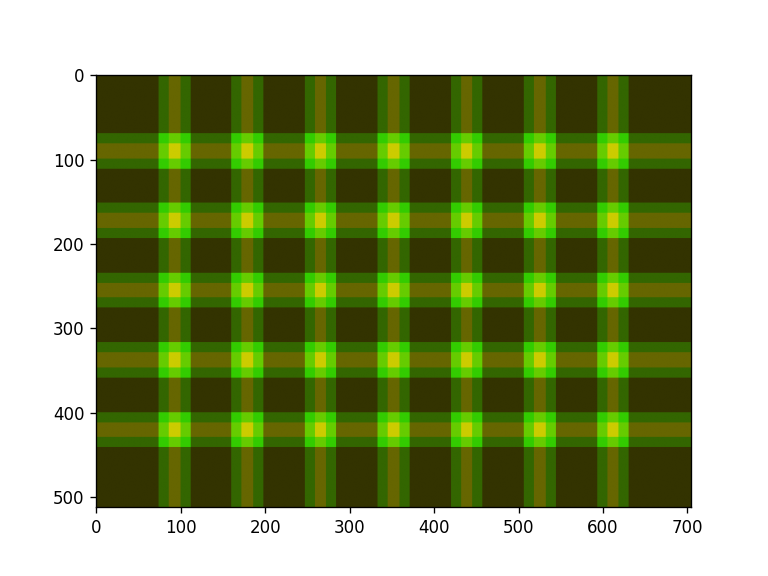

In [42]:
visualize_blocks(inner_blocks, outer_blocks, frame_height=frame_height, frame_width=frame_width)

## t-SNE parameters

In [43]:
# NN = sklearn.neighbors.NearestNeighbors(
# #         n_neighbors=100,  ## currently using min(sf_block_flat.shape[0], max_n_neighbors)
# #     radius=1.0, 
#     algorithm='auto',
#     leaf_size=30, 
#     metric='manhattan',
#     p=1,
# #     metric_params=None, 
#     n_jobs=-1
# )

method_tsne = 'barnes_hut' if len(sf_all) >= 4 else 'exact'
# method_tsne = 'exact'  # Slow. Use if you are looking for clusters with 3 or fewer samples in them, or for very high accuracy
print(f'Method used for t-SNE: {method_tsne}')

tsne = sklearn.manifold.TSNE(
    n_components=2,
#     perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate='auto',
#     learning_rate=,
    n_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='precomputed',
    init='random',
    verbose=0,
    random_state=None,
#     method='barnes_hut',
#     method='exact',
#     method=method_tsne,
    angle=0.01,  # high accuracy: 0.01, medium accuracy: 0.05, okay accuracy: 0.25, best accuracy: use method='exact'
    n_jobs=-1,
    square_distances=True,
)

Method used for t-SNE: barnes_hut


In [44]:
import umap

ModuleNotFoundError: No module named 'umap'

In [ ]:
umap_obj = umap.UMAP(
    n_neighbors=15,
    n_components=2,
#     metric='euclidean',
#     metric_kwds=None,
#     output_metric='euclidean',
#     output_metric_kwds=None,
    n_epochs=500,
    learning_rate=1.0,
#     init='spectral',
    min_dist=0.05,
    spread=3.0,
#     low_memory=True,
#     n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=6.0,
    repulsion_strength=3.0,
    negative_sample_rate=100,
#     transform_queue_size=40.0,
#     a=None,
#     b=None,
#     random_state=None,
#     angular_rp_forest=False,
#     target_n_neighbors=-1,
#     target_metric='categorical',
#     target_metric_kwds=None,
#     target_weight=0.5,
#     transform_seed=42,
#     transform_mode='embedding',
#     force_approximation_algorithm=False,
#     verbose=False,
#     tqdm_kwds=None,
#     unique=False,
#     densmap=False,
#     dens_lambda=2.0,
#     dens_frac=0.3,
#     dens_var_shift=0.1,
#     output_dens=False,
#     disconnection_distance=None,
#     precomputed_knn=(None, None, None),
)

In [ ]:
#### IMPORTANT PARAMETER: K-NEAREST NEIGHBORS ####
## Lower this to improve speed, but sacrifice some quality. 
## Choose a number that is > ~ the largest number of ROIs you think a single ROI might have any overlap with.
## For most datasets, values around 200 should give high quality results.
## Max value is 1023.
## Value must be > 3*perplexity.

max_n_neighbors = 100
max_perplexity = 10

##################################################


####### Other Parameters #######

## This parameter determines how 'binary'-looking masks are
## Small values = more binary. Large values weight bright pixels more
## mask_scaled = mask ** mask_power
mask_power = 0.3

## Embed ROIs in t-SNE space

In [ ]:
idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(ROIs_aligned)])

if pref_blurROIs:
# if False:
    ROIs_toUse = ROIs_aligned_blur
else:
    ROIs_toUse = ROIs_aligned

block_rois_raw = []
for i_block in tqdm(range(n_blocks)):
# for i_block in tqdm([0]):
    block_rois_raw.append(
        embed_ROIs(
            outer_blocks,
            inner_blocks,
            ROIs_toUse,
            frame_height,
            frame_width,
            idx_roi_session,
            tsne,
#             umap_obj,
            i_block,
            mask_power,
            max_n_neighbors,
            pref_use_NN_distances,
            latents,
            latents_swt,
            max_perplexity
        )
    )


### Visualize t-SNE and test clustering parameters

In [ ]:
%matplotlib notebook

block_toUse = 0
min_samples = 2
max_samples = 14 # for use within this cell only (visualization and titrating eps value). Set to None to speed up visualization

embeddings = block_rois_raw[block_toUse]['embeddings']
    
display_clustering_widget(embeddings, min_samples, max_samples=max_samples, min_slider=0.01, max_slider=10, start_slider=1.0, single_color=False)

## Set clustering parameters

- tune `eps_values` and to include desired range of eps values
- set `min_samples`

In [28]:
eps_values = np.arange(0.3, 11.0, 0.1)
min_samples = 3
cdbscan = clustering.cDBSCAN(
    eps_values=eps_values,
    min_samples=2,
    **{ 'metric_params': None, 
        'algorithm': 'auto',
        'leaf_size': 30, 
        'p': 2, 
        'n_jobs': -1 }
)

block_rois = run_clustering_sweep(block_rois_raw, cdbscan, idx_roi_session)

  0%|          | 0/48 [00:00<?, ?it/s]

In [29]:
# pickle_helpers.simple_save(block_rois, '/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/block_rois_valerio1_distal.pkl')

In [30]:
# block_rois = pickle_helpers.simple_load('/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/block_rois.pkl')

the following block should be able to get folded into the main loop above. Just need to break the list comprehension up into a real for loop and index into both the inner and outer blocks

## Get ROI properties
1. Cluster size (n_roi in cluster)
2. Cluster mean of distances (mean of differences between spatial footprints)
3. Cluster std of distances (variance of differences between spatial footprints)
4. Cluster max of distances (max of differences between spatial footprints)

Heuristic to determine which block to trust for each ROI:

- for each block, determine how many rois are a part of each cluster
- for each roi, determine how many 'neighbor' rois are in it's cluster


- then, for each roi, trust the block that clustered it with the greatest number of ROIs that wasn't too many (ranges between a user defined range)

In [31]:
ROIs_aligned_cat = scipy.sparse.vstack(ROIs_aligned)
ROIs_aligned_cat_scaled = ROIs_aligned_cat
ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.power(mask_power)
ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.multiply( 1 / ROIs_aligned_cat_scaled.sum(1) )
ROIs_aligned_cat_scaled = scipy.sparse.csr_matrix(ROIs_aligned_cat_scaled)

combined_distances = combine_distances_from_blocks(block_rois_raw, n_roi_all)

# distances_clusters = [[]]*len(block_rois)
distances_clusters = [[combined_distances[idx_clust][:, idx_clust] for idx_clust in block['clusters_idx_unique']]for block in tqdm(block_rois)]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [32]:
# ROIs_aligned_cat = scipy.sparse.vstack(ROIs_aligned)
# ROIs_aligned_cat_scaled = ROIs_aligned_cat
# ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.power(mask_power)
# ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.multiply( 1 / ROIs_aligned_cat_scaled.sum(1) )
# ROIs_aligned_cat_scaled = scipy.sparse.csr_matrix(ROIs_aligned_cat_scaled)

# combined_distances = combine_distances_from_blocks(block_rois_raw, n_roi_all)

# distances_clusters = [[]]*len(block_rois)
# for i_block, block in enumerate(tqdm(block_rois)):
#     labels = block['db'].labels_
#     uci = block['labels_unique']
#     distances_clusters[i_block] = [[]]*len(uci)
#     for i_cid, cid in enumerate(uci):
#         roi_idx_cluster = np.where(labels == cid)[0]
#         roi_idx = block['idxCat_ROI_inOuterBlock'][roi_idx_cluster]
        
#         distances_clusters[i_block][i_cid] = combined_distances[roi_idx][:,roi_idx]

In [33]:
## Calculate statistics of distance matrices
fn_dist_mean = lambda x: np.mean(x[np.triu_indices(x.shape[0], k=1)])
fn_dist_std = lambda x: np.std(x[np.triu_indices(x.shape[0], k=1)])
fn_dist_max = lambda x: np.max(x[np.triu_indices(x.shape[0], k=1)])

dist_mean_all = [ [fn_dist_mean(distances_clusters[i_block][ii].toarray()) for ii in range(len(distances_clusters[i_block]))] for i_block in tqdm(range(len(distances_clusters))) ]
dist_std_all  = [ [fn_dist_std(distances_clusters[i_block][ii].toarray())  for ii in range(len(distances_clusters[i_block]))] for i_block in tqdm(range(len(distances_clusters))) ]
dist_max_all  = [ [fn_dist_max(distances_clusters[i_block][ii].toarray())  for ii in range(len(distances_clusters[i_block]))] for i_block in tqdm(range(len(distances_clusters))) ]

dist_mean_all_cat = np.concatenate(dist_mean_all)
dist_std_all_cat  = np.concatenate(dist_std_all)
dist_max_all_cat  = np.concatenate(dist_max_all)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Plots for distance metrics

Set inclusion thresholds

In [34]:
cluster_properites = {
    "n_roi": np.concatenate([block['sizes_clusters'] for block in block_rois]),
    "clusters_fromUniqueSessions": np.concatenate([block['cluster_sessions_isUnique'] for block in block_rois]),
    "cluster_distance_mean": dist_mean_all_cat,
    "cluster_distance_std": dist_std_all_cat,
    "cluster_distance_max": dist_max_all_cat,
    "cluster_consistency": np.concatenate([block['clusters_idx_unique_freq'] for block in block_rois]) / len(eps_values),
}

<IPython.core.display.Javascript object>


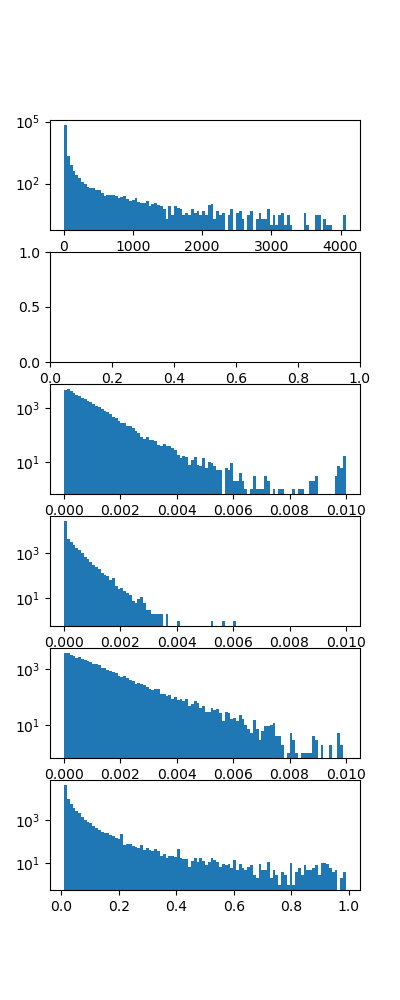

n_roi
cluster_distance_mean
cluster_distance_std
cluster_distance_max
cluster_consistency


In [117]:
fig, axs = plt.subplots(len(cluster_properites), figsize=(4,10))
for ii, (key, val) in enumerate(cluster_properites.items()):
    if key == 'clusters_fromUniqueSessions':
        continue
    print(key)
    
    if (key == 'cluster_consistency') or (key == 'n_roi'):
        axs[ii].hist(val, 100, range=None)
    else:
        axs[ii].hist(val, 100, range=(0, 0.01))
    axs[ii].set_yscale('log')

In [142]:
cluster_inclusion_criteria_ranges = {
    "n_roi": (3, n_sessions),
    "clusters_fromUniqueSessions": (True,True),
    "cluster_distance_mean": (0,0.008),
    "cluster_distance_std": (0,0.008),
    "cluster_distance_max": (0,0.008),
    "cluster_consistency": tuple(np.array([0.00, 1.0]))
}

Assign cluster scores by inner blocks to each ROI. \
output (roi_cluster_properties) is a dictionary. 1 entry for each property. entry shape: (n_blocks, n_roi)

In [143]:
roi_cluster_multihot = scipy.sparse.csr_matrix(np.concatenate([np.array([indexing.idx2bool(cluster, length=n_roi_all) for cluster in block['clusters_idx_unique']]) for block in block_rois]))

In [144]:
def bool_in_range(array, range_vals):
    return (array >= range_vals[0]) * (array <= range_vals[1])

roi_cluster_inclusion_allProperties = {key: bool_in_range(cluster_properites[key], cluster_inclusion_criteria_ranges[key]) for key,val in cluster_properites.items()}
roi_cluster_inclusion = np.stack(tuple(roi_cluster_inclusion_allProperties.values())).prod(0).astype(np.bool8)

In [145]:
rois_included = roi_cluster_inclusion
list_eligible = copy.copy(rois_included)

clusterScores = (cluster_properites['cluster_consistency']**1) * ((cluster_properites['n_roi']/n_sessions)**1)
# clusterScores = (cluster_properites['n_roi']/n_sessions)

UC_roiIdx = []
UCIDs = np.ones(n_roi_all).astype(np.int64) * -1
i_ucid = 0
while list_eligible.sum() > 0:
#     print(list_eligible.sum())
    cluster_toPick = np.argmax(clusterScores[list_eligible])
#     cluster_toPick = 0
    UC_roiIdx_tmp = roi_cluster_multihot[list_eligible][cluster_toPick].toarray().squeeze()
#     UC_roiIdx_tmp = 0
    idx_otherClustersWithUCRois = (roi_cluster_multihot[list_eligible] @ UC_roiIdx_tmp) > 0
#     idx_otherClustersWithUCRois = np.zeros(roi_cluster_multihot_included[list_eligible].shape[0]).astype(np.bool8)
    
    idx_toDelete = idx_otherClustersWithUCRois
    idx_toDelete[cluster_toPick] = True
    
    list_eligible[np.where(list_eligible)[0][idx_toDelete]] = False
    
    UC_roiIdx.append(UC_roiIdx_tmp)
    UCIDs[UC_roiIdx_tmp] = i_ucid
    i_ucid += 1

In [146]:
UCIDs_rough = copy.copy(UCIDs)

In [147]:
np.array(UC_roiIdx).shape

(4316, 30645)

In [148]:
# n_blocks = len(block_rois)
# n_properties = len(cluster_properites)

# # roi_labelFreqs = np.ones((len(block_rois), n_roi_all)) * np.nan # shape (n_blocks, n_roi_total)
# roi_cluster_properties = {key: np.ones((n_blocks, n_roi_all)) * np.nan for key,val in cluster_properites.items()}

# for i_block, block in enumerate(tqdm(block_rois)):
#     labels = block['db'].labels_
#     labels_unique = np.unique(labels)
# #     label_sizes = [list(labels).count(label) for label in labels_unique]
    
#     bool_outer = block_rois[i_block]['boolCat_ROI_inOuterBlock']
#     idx_outer  = block_rois[i_block]['idxCat_ROI_inOuterBlock']
    
#     bool_inner = np.concatenate(block_rois[i_block]['bool_ROI_inInnerBlock_allSesh'])
#     idx_inner = np.where(bool_inner)[0]
    
#     for i_roi in range(n_roi_all): # for every ROI
#         if i_roi in idx_outer: # check if roi was in the outer frame
            
#             if i_roi in idx_inner: # check if roi was in the inner frame
#                 arg_outer = np.where(i_roi == idx_outer) # get argument in outer list of this roi
#                 label = labels[arg_outer] # get the label of this roi in this block
#                 arg_unique = np.where(labels_unique == label)[0][0] # get the idx/arg of of the labels_unique label
                
                
#                 for i_property, (key, val) in enumerate(cluster_properites.items()):
#                     roi_cluster_properties[key][i_block, i_roi] = val[i_block][arg_unique]
# #                     print(val[i_block][arg_unique])
# #                     print(roi_cluster_properties[key][i_block, i_roi])
# #                     roi_cluster_properties

In [149]:
# def bool_in_range(array, range_vals):
#     return (array >= range_vals[0]) * (array <= range_vals[1])

In [150]:
# roi_cluster_inclusion_allProperties = {key: bool_in_range(roi_cluster_properties[key], cluster_inclusion_criteria_ranges[key]) for key,val in roi_cluster_properties.items()}
# roi_cluster_inclusion = np.stack(tuple(roi_cluster_inclusion_allProperties.values())).prod(0)

- randomly choose rois from a list of all eligible ROIs
<!-- - randomly choose a block that meet criteria for that roi, -->
- choose the available cluster with the largest numbers of ROIs in it
- find what other rois are a part of the cluster that it's in
    - find what it's cluster label is for that block
    - find other rois with that cluster label
- assign that roi and all of the rois in that cluster a UCID
- remove all those rois from the list to choose from

- change step 2 to be 'best block'

In [151]:
# UCIDs_rough = np.ones(n_roi_all, dtype=np.int64) * -1
# rois_included = np.where(roi_cluster_inclusion.sum(0) > 0)[0]
# list_eligible = copy.copy(rois_included)
# ucid_new = 0
# bunch_of_nans = np.ones(len(UCIDs_rough))*np.nan
# UCID_properties = {
#     'block':                 copy.copy(bunch_of_nans),
#     'idx_in_outerBlock':     copy.copy(bunch_of_nans),
#     'label_in_outerBlock':   copy.copy(bunch_of_nans),
#     "n_roi_in_Cluster":      copy.copy(bunch_of_nans),
#     "cluster_distance_mean": copy.copy(bunch_of_nans),
#     "cluster_distance_std":  copy.copy(bunch_of_nans),
#     "cluster_distance_max":  copy.copy(bunch_of_nans),
#     "session":               idx_roi_session,
# }
# while len(list_eligible) > 0: # while there are still values that have not been deleted
#     idx_inList = random.choice(list_eligible)
# #     idx_inList = list_eligible[0]
# #     block_toUse = random.choice(np.where(roi_cluster_inclusion[:,idx_inList] > 0)[0])
#     block_toUse = np.argmax(roi_cluster_inclusion_allProperties['n_roi'][:,idx_inList])
#     idx_in_block = np.where(block_rois[block_toUse]['idxCat_ROI_inOuterBlock'] == idx_inList)[0]
#     label = block_rois[block_toUse]['db'].labels_[idx_in_block]
#     idx_others_in_block = np.where(block_rois[block_toUse]['db'].labels_ == label)[0]
#     idx_others = block_rois[block_toUse]['idxCat_ROI_inOuterBlock'][idx_others_in_block]
    
#     if np.sum(np.isin(idx_others, np.where(UCIDs_rough>=0)[0]) > 0):
#         list_eligible = np.delete(list_eligible, np.where(np.isin(list_eligible, idx_inList))[0])
#         continue
    
#     UCIDs_rough[idx_others] = ucid_new
#     ucid_new += 1
    
#     list_eligible = np.delete(list_eligible, np.where(np.isin(list_eligible, idx_others))[0])
    
    
#     UCID_properties['block'][idx_others] = block_toUse
#     UCID_properties['idx_in_outerBlock'][idx_others] = idx_others_in_block
#     UCID_properties['label_in_outerBlock'][idx_others] = label
#     UCID_properties['n_roi_in_Cluster'][idx_others] = roi_cluster_properties['n_roi'][block_toUse][idx_others]
#     UCID_properties['cluster_distance_mean'][idx_others] = roi_cluster_properties['cluster_distance_mean'][block_toUse][idx_others]
#     UCID_properties['cluster_distance_std'][idx_others] = roi_cluster_properties['cluster_distance_std'][block_toUse][idx_others]
#     UCID_properties['cluster_distance_max'][idx_others] = roi_cluster_properties['cluster_distance_max'][block_toUse][idx_others]

In [152]:
# UCIDs = UCIDs_rough

<IPython.core.display.Javascript object>


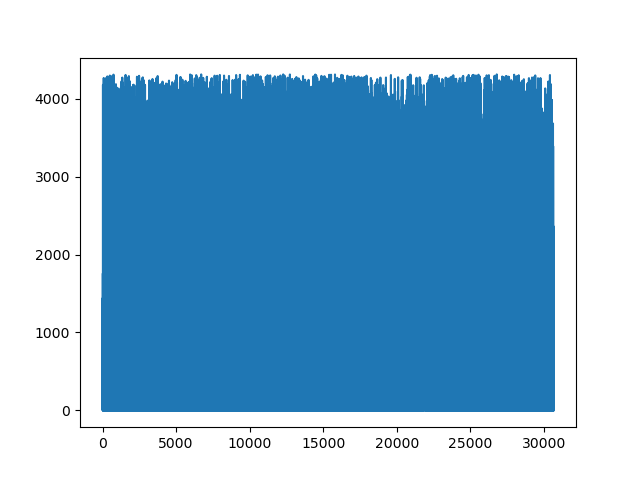

In [153]:
plt.figure()
plt.plot(UCIDs_rough)

In [154]:
def values_with_counts_outside_of_range(values, val_range, verbose=True):
    unique_values = np.unique(values)
    unique_counts = np.array([np.sum(values==val) for val in unique_values])
    bad_outOfRange = unique_values[
        np.logical_not(np.isin(
            unique_counts,
                np.arange(val_range[0], val_range[1]+1)
        ))
    ]
    print(f'Found bad values: {bad_outOfRange}')
    return bad_outOfRange

In [155]:
print(f'number of unique clusters: {len(np.unique(UCIDs_rough))}')

number of unique clusters: 4317


In [156]:
bad_UCIDs = values_with_counts_outside_of_range(UCIDs_rough, cluster_inclusion_criteria_ranges['n_roi'])
UCIDs = copy.copy(UCIDs_rough)
UCIDs[np.isin(UCIDs, bad_UCIDs)] = -1
UCIDs = classification.squeeze_integers(UCIDs)
# UCID_properties['UCID'] = UCIDs
# values_with_counts_outside_of_range(UCIDs, cluster_inclusion_criteria_ranges['n_roi']);

Found bad values: [-1]


In [157]:
unique_UCIDs = np.unique(UCIDs)

In [158]:
bounds_idx_roi_per_sesh = np.concatenate([[0], np.cumsum(n_roi_per_sesh)])
UCIDs_bySession = [UCIDs[bounds_idx_roi_per_sesh[ii]:bounds_idx_roi_per_sesh[ii+1]] for ii in range(n_sessions)]

In [159]:
# make a UCID x session matrix (boolean)
UCIDs_inSession = np.array([np.isin(unique_UCIDs, UCIDs_bySession[i_sesh]) for i_sesh in range(n_sessions)])
if np.sum(UCIDs_inSession==0):
    print(f'WARNING: Make sure you are okay with the fact that there are sessions where clusters are not present')
if np.sum(UCIDs_inSession>1):
    print(f'WARNING: Make sure you are okay with the fact that there are sessions where a single cluster has more than ROI in it')

# Colored clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

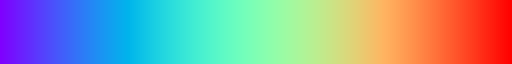

In [160]:
plt.get_cmap('rainbow')

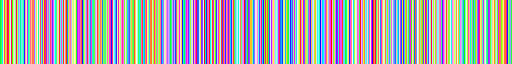

In [169]:
cmap = plotting_helpers.rand_cmap(len(np.unique(UCIDs_rough)), type='bright', first_color_black=False, verbose=False)
cmap.set_extremes(under=(1,1,1,1))
cmap

In [170]:
n_planes = n_sessions
labels = UCIDs
# labels = labels

ucid_toUse = labels
idx_roi_session_toUse = idx_roi_session

# cmaps = sparse.COO(rand_cmap(len(np.unique(ucid_toUse)), verbose=False)(np.int32(ucid_toUse))[:,:3])
cmaps = sparse.COO(cmap(np.int32(ucid_toUse))[:,:3])
plane_oneHot = classification.idx_to_oneHot(idx_roi_session_toUse.astype(np.int32))

ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))
ROIs_csr_scaled = ROIs_csr.multiply(ROIs_csr.max(1).power(-1))
ROIs_sCOO = sparse.COO(ROIs_csr_scaled)

def tile_sparse(arr, n_tiles):
    """
    tiles along new (last) dimension
    """
    out = sparse.stack([arr for _ in range(n_tiles)], axis=-1)
    return out

ROIs_tiled = tile_sparse(tile_sparse(ROIs_sCOO, n_planes), 3)

ROIs_colored = ROIs_tiled * cmaps[:,None,None,:] * plane_oneHot[:,None,:,None]

FOV_ROIs_colored = ROIs_colored.sum(0).reshape((frame_height, frame_width, n_planes, 3)).transpose((2,0,1,3))

In [171]:
FOV_all_noClip = copy.copy(FOV_ROIs_colored.todense())
FOV_all_noClip[FOV_all_noClip>1] = 1

<IPython.core.display.Javascript object>


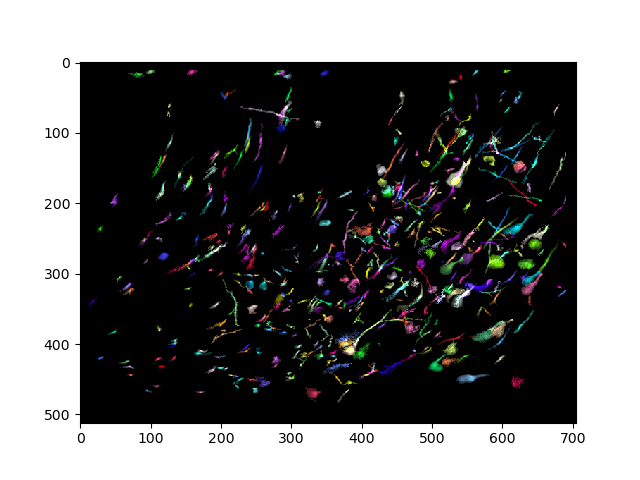

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [87]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

<IPython.core.display.Javascript object>


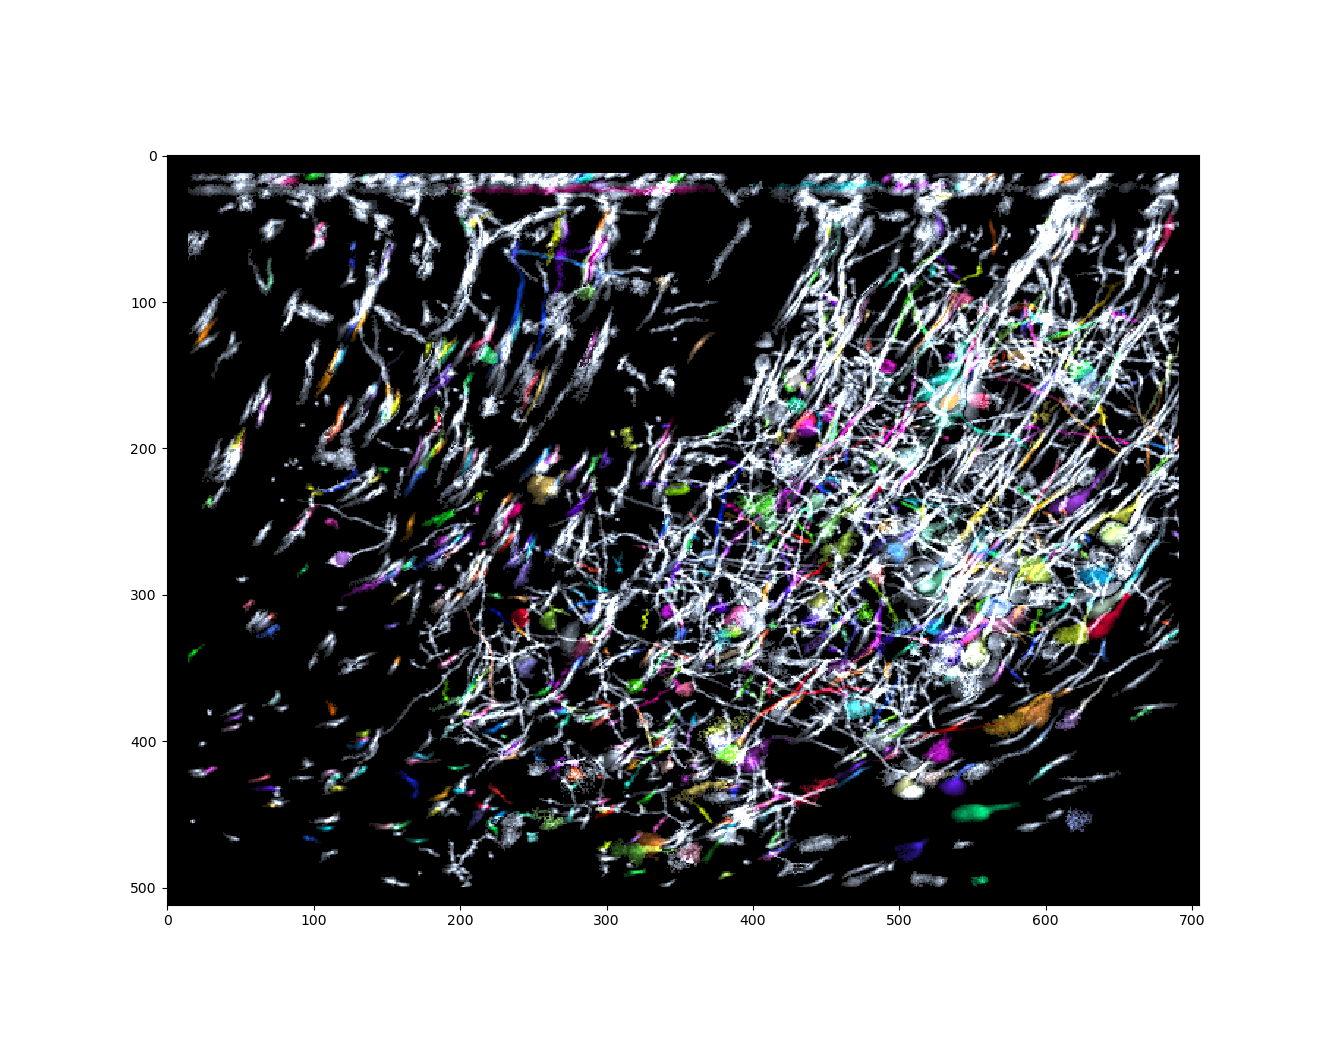

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [141]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

<IPython.core.display.Javascript object>


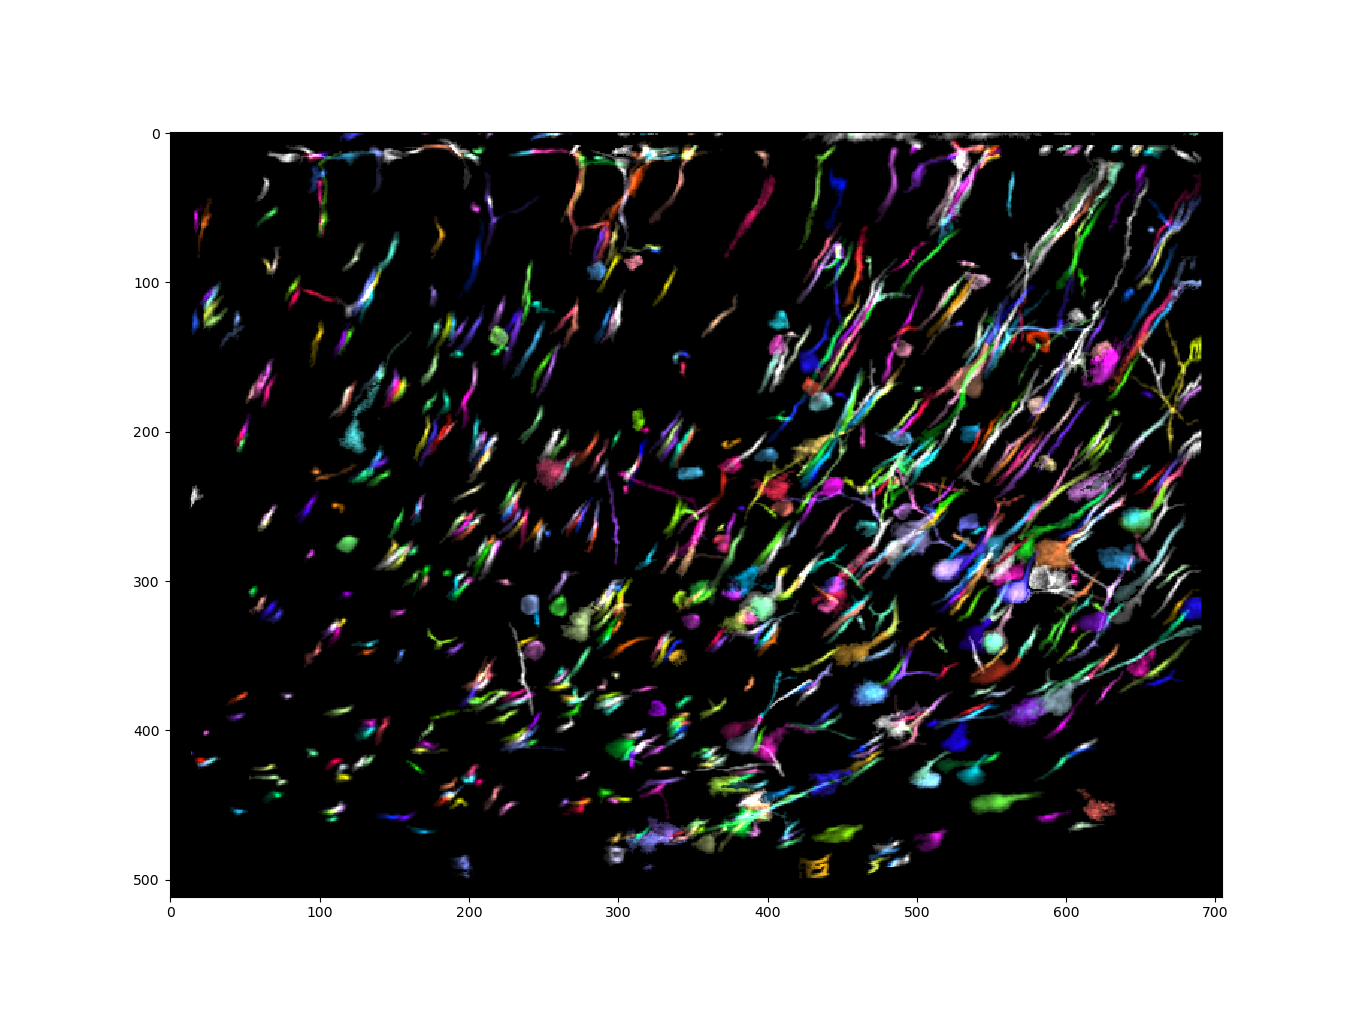

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [172]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

<IPython.core.display.Javascript object>


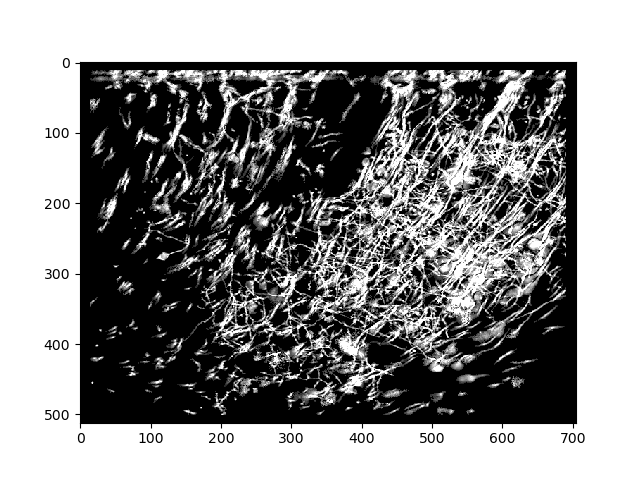

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [110]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

<IPython.core.display.Javascript object>


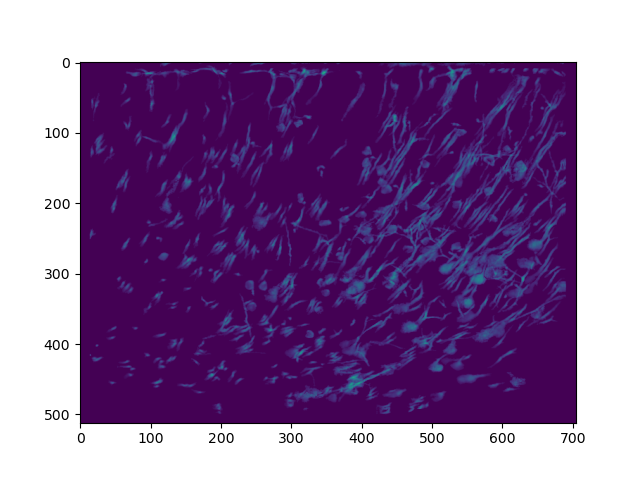

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [111]:
display_toggle_image_stack([rois.multiply( rois.max(1).power(-1) ).sum(0).reshape(frame_height, frame_width) for rois in ROIs_aligned], clim=None)

outputs:
`UCIDs`
`UCIDs_bySession`

In [59]:
## Only need to run this once since it is just pulling from stuff that should be static

ROIs_raw = scipy.sparse.vstack([scipy.sparse.csr_matrix(rois.reshape(rois.shape[0], -1)) for rois in tqdm(sf_all)])

ROIs = {
    "ROIs_aligned": ROIs_aligned,
    "ROIs_raw": ROIs_raw,
    "frame_height": frame_height,
    "frame_width": frame_width,
    "idx_roi_session": idx_roi_session
}

  0%|          | 0/14 [00:00<?, ?it/s]

In [60]:
name_save = os.path.split(dir_allOuterFolders)[-1]

In [61]:
dir_save = Path(r'/media/rich/bigSSD/analysis_data/ROI_tracking/Valerio/4th_email/results/').resolve()

In [62]:
pickle_helpers.simple_save(
    {
        "UCIDs": UCIDs,
        "UCIDs_bySession": UCIDs_bySession,
        "ROIs": ROIs  
    },
    filename= dir_save / (name_save + '_plane1_UCIDs.pkl'),
)